In [63]:
# import the required packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# tokenization
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# classification modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
nltk.data.path

['/Users/zach/nltk_data',
 '/opt/anaconda3/nltk_data',
 '/opt/anaconda3/share/nltk_data',
 '/opt/anaconda3/lib/nltk_data',
 '/usr/share/nltk_data',
 '/usr/local/share/nltk_data',
 '/usr/lib/nltk_data',
 '/usr/local/lib/nltk_data']

In [4]:
# download required datasets to train NLTK models
nltk.download("punkt")
nltk.download("punkt_tab")

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to /Users/zach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/zach/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zach/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/zach/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zach/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### 1.1 Text data pre-processing

In [5]:
# load text data
dat = pd.read_csv("AA_movie_train_data.csv")
dat.head()

,Title,Genre,Description
0,Windup (2006),action,Windup is a very original comedy. We follow B...
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...


In [6]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        5000 non-null   object
 1   Genre        5000 non-null   object
 2   Description  5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [7]:
dat["Genre"].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

### 1.2 Cleanse text data

In [8]:
def pre_process(text: str) -> str:
    text = text.lower()
    text = re.sub('[^A-Za-z]', " ", text)
    return text

In [9]:
def get_stopwords(filepath: str) -> frozenset[str]:
    with open(filepath, 'r') as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [10]:
# apply text cleaning on descriptions column
descriptions = dat["Description"].dropna().astype(str)
descriptions_all = descriptions.apply(pre_process)
tokenized_desc = [word_tokenize(sentence) for sentence in descriptions_all]

In [11]:
print(tokenized_desc[0])

['windup', 'is', 'a', 'very', 'original', 'comedy', 'we', 'follow', 'bernie', 'shaddick', 'from', 'his', 'tragic', 'childhood', 'through', 'to', 'his', 'present', 'day', 'pursuit', 'of', 'a', 'career', 'as', 'an', 'inventor', 'likened', 'to', 'such', 'films', 'as', 'raising', 'arizona', 'and', 'the', 'big', 'lebowski', 'gritty', 'cohen', 'esque', 'humor', 'saturates', 'bernie', 'shaddick', 's', 'life', 'from', 'his', 'encounter', 'with', 'mace', 'at', 'a', 'potential', 'sale', 'to', 'his', 'murderous', 'mentors', 'posing', 'as', 'his', 'aunt', 'audre', 'and', 'uncle', 'reg', 'bernie', 'is', 'a', 'man', 'who', 'in', 'the', 'face', 'of', 'rejection', 'and', 'ridicule', 'just', 'doesn', 't', 'get', 'it', 'and', 'perseveres', 'anyways', 'his', 'good', 'nature', 'gets', 'on', 'the', 'nerves', 'of', 'his', 'cruel', 'co', 'workers', 'at', 'his', 'commercial', 'real', 'estate', 'day', 'job', 'upholding', 'an', 'almost', 'delusional', 'enthusiasm', 'bernie', 'unknowingly', 'sells', 'his', 'soul

In [12]:
# remove stopwords

stopwords = list(get_stopwords("stopwords.txt"))

filtered_desc = [
    [word for word in sentence if word not in stopwords]
    for sentence in tokenized_desc
]

print(dat["Description"][0])
print(filtered_desc[0])

 Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick's life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn't get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie's girlfriend Latrice and roommate Stuart only accentuate Bernie's seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie because it

In [13]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    return {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }.get(tag, wordnet.NOUN)

# Apply lemmatization with POS tagging
lemmatized_desc = [
    [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sentence]
    for sentence in filtered_desc
]

print(lemmatized_desc[0])

['windup', 'original', 'comedy', 'follow', 'bernie', 'shaddick', 'tragic', 'childhood', 'day', 'pursuit', 'career', 'inventor', 'liken', 'film', 'raise', 'arizona', 'lebowski', 'gritty', 'cohen', 'esque', 'humor', 'saturates', 'bernie', 'shaddick', 'life', 'encounter', 'mace', 'potential', 'sale', 'murderous', 'mentor', 'pose', 'aunt', 'audre', 'uncle', 'reg', 'bernie', 'rejection', 'ridicule', 'doesn', 'perseveres', 'anyways', 'nature', 'nerve', 'cruel', 'co', 'worker', 'commercial', 'real', 'estate', 'day', 'job', 'uphold', 'delusional', 'enthusiasm', 'bernie', 'unknowingly', 'sell', 'soul', 'smile', 'bernie', 'girlfriend', 'latrice', 'roommate', 'stuart', 'accentuate', 'bernie', 'seemingly', 'pathetic', 'existence', 'latrice', 'sexy', 'dirty', 'sort', 'love', 'bernie', 'prefer', 'love', 'money', 'stuart', 'usually', 'clad', 'underpants', 'obsess', 'rubix', 'cube', 'life', 'bernie', 'allows', 'pursue', 'beer', 'welfare', 'check', 'latrice', 'myriad', 'flashback', 'eccentric', 'aunt',

### 1.3 Bag of word

In [14]:
# convert keywords back into str for bow
cleaned_texts = [" ".join(tokens) for tokens in filtered_desc]

In [15]:
# vectorizer
vectorizer = CountVectorizer(max_df=0.8, max_features=5000)
bow_matrix = vectorizer.fit_transform(cleaned_texts)

In [16]:
# extracting word frequencies
sum_words = bow_matrix.sum(axis=0)

bow_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bow_freq = sorted(bow_freq, key=lambda x: x[1], reverse=True)

print("Highest freq words: ")
bow_freq[0:20]

Highest freq words: 


[('life', 2304),
 ('film', 1416),
 ('world', 1364),
 ('family', 1280),
 ('time', 1169),
 ('story', 1143),
 ('love', 1063),
 ('people', 952),
 ('father', 861),
 ('own', 842),
 ('lives', 838),
 ('day', 819),
 ('friends', 765),
 ('mother', 726),
 ('wife', 720),
 ('home', 718),
 ('son', 694),
 ('police', 658),
 ('woman', 650),
 ('help', 648)]

In [17]:
feature_names = np.array(vectorizer.get_feature_names_out())

len(vectorizer.get_feature_names_out())

5000

In [18]:
bow_matrix.shape

(5000, 5000)

In [19]:
bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns = vectorizer.get_feature_names_out()
)

bow_df.head()

,aaron,aarti,abandon,abandoned,abby,abducted,abilities,ability,able,aboard,...,youth,youths,youtube,zach,zero,zhang,zoe,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 TF-IDF

In [20]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)

tfidf_matrix = tfidf_transformer.fit_transform(bow_df)

In [21]:
tfidf_transformer.idf_.shape

(5000,)

In [22]:
sorted_by_tfidf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_tfidf[:100]]))

Features with lowest idf:
['life' 'world' 'time' 'film' 'story' 'family' 'love' 'own' 'people'
 'lives' 'day' 'takes' 'help' 'friends' 'father' 'home' 'wife' 'woman'
 'friend' 'death' 'soon' 'son' 'mother' 'girl' 'city' 'police' 'goes'
 'comes' 'daughter' 'night' 'town' 'live' 'decides' 'documentary' 'past'
 'local' 'house' 'set' 'school' 'brother' 'begins' 'living' 'series'
 'meets' 'journey' 'money' 'women' 'killed' 'real' 'named' 'job' 'fight'
 'left' 'war' 'tries' 'dead' 'movie' 'husband' 'trying' 'american'
 'secret' 'true' 'country' 'little' 'former' 'meet' 'follows'
 'relationship' 'beautiful' 'evil' 're' 'sister' 'children' 'finally'
 'murder' 'save' 'look' 'human' 'history' 'called' 'tells' 'business'
 'events' 'mysterious' 'start' 'team' 'themselves' 'lost' 'makes' 'starts'
 'power' 'days' 'personal' 'bring' 'discovers' 'falls' 'stories' 'run'
 'escape' 'parents']


In [23]:
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_transformer.get_feature_names_out()
)

tfidf_df.head()

,aaron,aarti,abandon,abandoned,abby,abducted,abilities,ability,able,aboard,...,youth,youths,youtube,zach,zero,zhang,zoe,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
max_value = tfidf_matrix.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['grabs' 'replace' 'obsessive' 'seriously' 'flees' 'verma' 'actually'
 'employed' 'hold' 'shoots' 'continued' 'receiving' 'odds' 'nearly'
 'arrests' 'responsible' 'nearby' 'teach' 'attends' 'cruel']
Features with highest tfidf: 
['fort' 'flint' 'shakti' 'kishan' 'yoga' 'axel' 'es' 'perry' 'bernie'
 'jaswant' 'selma' 'bernard' 'sreeram' 'vs' 'jo' 'coral' 'laundry' 'am'
 'wine' 'comme']


### 2.1 Extracting keywords from TF-IDF matrix

In [25]:
idx = 0
doc = descriptions_all[idx]
print(doc)

tf_idf_vector = tfidf_matrix[idx]
print(tf_idf_vector.shape)

 windup is a very original comedy  we follow bernie shaddick from his tragic childhood  through to his present day pursuit of a career as an inventor  likened to such films as  raising arizona  and  the big lebowski   gritty cohen esque humor saturates bernie shaddick s life  from his encounter with mace at a potential sale  to his murderous mentors posing as his aunt audre and uncle reg  bernie is a man who  in the face of rejection and ridicule  just  doesn t get it   and perseveres anyways  his good nature gets on the nerves of his cruel co workers at his commercial real estate day job  upholding an almost delusional enthusiasm  bernie unknowingly sells his soul with a smile  bernie s girlfriend latrice and roommate stuart only accentuate bernie s seemingly pathetic existence  latrice  sexy in a dirty sort of way  loves bernie  although she would prefer to love his money  if he had any  stuart  usually clad in underpants and obsessed with the rubix cube  lives with bernie because it

In [26]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

,feature_number,tf_idf
0,58,0.033407
1,150,0.042240
2,245,0.048496
3,329,0.177631
4,410,0.044131
...,...,...
90,4708,0.045981
91,4738,0.042450
92,4942,0.033527
93,4954,0.076237


In [27]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

,feature_number,tf_idf
5,442,0.871016
3,329,0.177631
89,4673,0.147410
72,3601,0.105908
84,4286,0.103222
...,...,...
20,1126,0.024807
43,1911,0.024236
56,2661,0.020924
57,2700,0.020288


In [28]:
#use only topn items from vector

topn = 10   
topn_items = temp[:topn]

tf_idf = []
word = []

for index, row in topn_items.iterrows():
    fname = feature_names[int(row['feature_number'])]
    word.append(fname)
    tf_idf.append(round(row['tf_idf'], 3))    

print(doc, '\n')

result = dict(zip(word, tf_idf))
print(result)

 windup is a very original comedy  we follow bernie shaddick from his tragic childhood  through to his present day pursuit of a career as an inventor  likened to such films as  raising arizona  and  the big lebowski   gritty cohen esque humor saturates bernie shaddick s life  from his encounter with mace at a potential sale  to his murderous mentors posing as his aunt audre and uncle reg  bernie is a man who  in the face of rejection and ridicule  just  doesn t get it   and perseveres anyways  his good nature gets on the nerves of his cruel co workers at his commercial real estate day job  upholding an almost delusional enthusiasm  bernie unknowingly sells his soul with a smile  bernie s girlfriend latrice and roommate stuart only accentuate bernie s seemingly pathetic existence  latrice  sexy in a dirty sort of way  loves bernie  although she would prefer to love his money  if he had any  stuart  usually clad in underpants and obsessed with the rubix cube  lives with bernie because it

In [29]:
# extract keywords for all reviews

topn = 10
first_results = []

for idx, doc in descriptions_all.items():
    #generate tf-idf for the given document
    tf_idf_vector = tfidf_matrix[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data), columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    first_results.append(result)


In [30]:
len(first_results)

5000

In [31]:
dat["cleaned_desc"] = descriptions_all
dat["keywords"] = first_results
dat.head()

,Title,Genre,Description,cleaned_desc,keywords
0,Windup (2006),action,Windup is a very original comedy. We follow B...,windup is a very original comedy we follow b...,"{'bernie': 0.871, 'aunt': 0.178, 'uncle': 0.14..."
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ...",rana and shuvo two siblings are very differ...,"{'rana': 0.686, 'crime': 0.184, 'brother': 0.1..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...,when a san francisco detective goes hunting f...,"{'nelson': 0.524, 'violent': 0.215, 'detective..."
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i...",a man name lam picks up his girlfriend but i...,"{'lam': 0.713, 'gangster': 0.408, 'martial': 0..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...,thap and sin are a homeless musician brothers...,"{'ram': 0.534, 'sin': 0.52, 'prince': 0.358, '..."


In [32]:
dat.to_csv("descriptions_export.csv")

In [33]:
# export lemmatized_desc to csv for ARM

lemmatized_df = pd.DataFrame(lemmatized_desc)
lemmatized_df.to_csv("lemmatized_desc.csv", index=False, header=False)

### 2.2 Association Rule Mining

### Generating association rules

In [34]:
desc_data = pd.read_csv("lemmatized_desc.csv", header=None)
desc_data.head()

/var/folders/_r/r36h10zs0nq81n14fr_t58pw0000gn/T/ipykernel_23305/1049722890.py:1: DtypeWarning: Columns (277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500

,0,1,2,3,4,5,6,7,8,9,...,656,657,658,659,660,661,662,663,664,665
0,windup,original,comedy,follow,bernie,shaddick,tragic,childhood,day,pursuit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rana,shuvo,sibling,father,police,constable,death,shuvo,assumes,duty,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,san,francisco,detective,go,hunt,cruel,asian,crime,figure,kill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,name,lam,pick,girlfriend,reveal,girlfriend,actually,relationship,evil,gangster,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,thap,sin,homeless,musician,brother,village,raid,khun,ram,try,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
desc_data.shape

(5000, 666)

In [36]:
full_list=pd.Series([])
for col in desc_data:
    full_list = full_list._append(desc_data[col].dropna())

print(full_list)

0           windup
1             rana
2              san
3             name
4             thap
           ...    
4372          evil
4372           use
4372        helena
4372    appearance
4372        seduce
Length: 348234, dtype: object


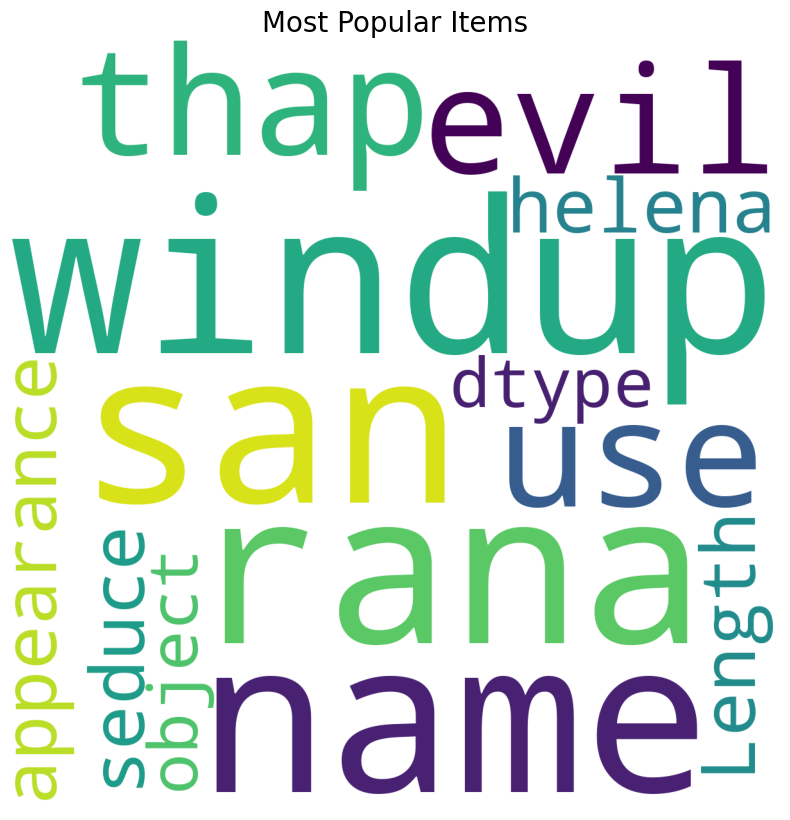

In [37]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(full_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

In [38]:
full_list.value_counts()

life           3146
film           1653
story          1418
world          1417
family         1414
               ... 
gilford           1
stile             1
phillippine       1
oztoberfest       1
occultism         1
Name: count, Length: 32681, dtype: int64

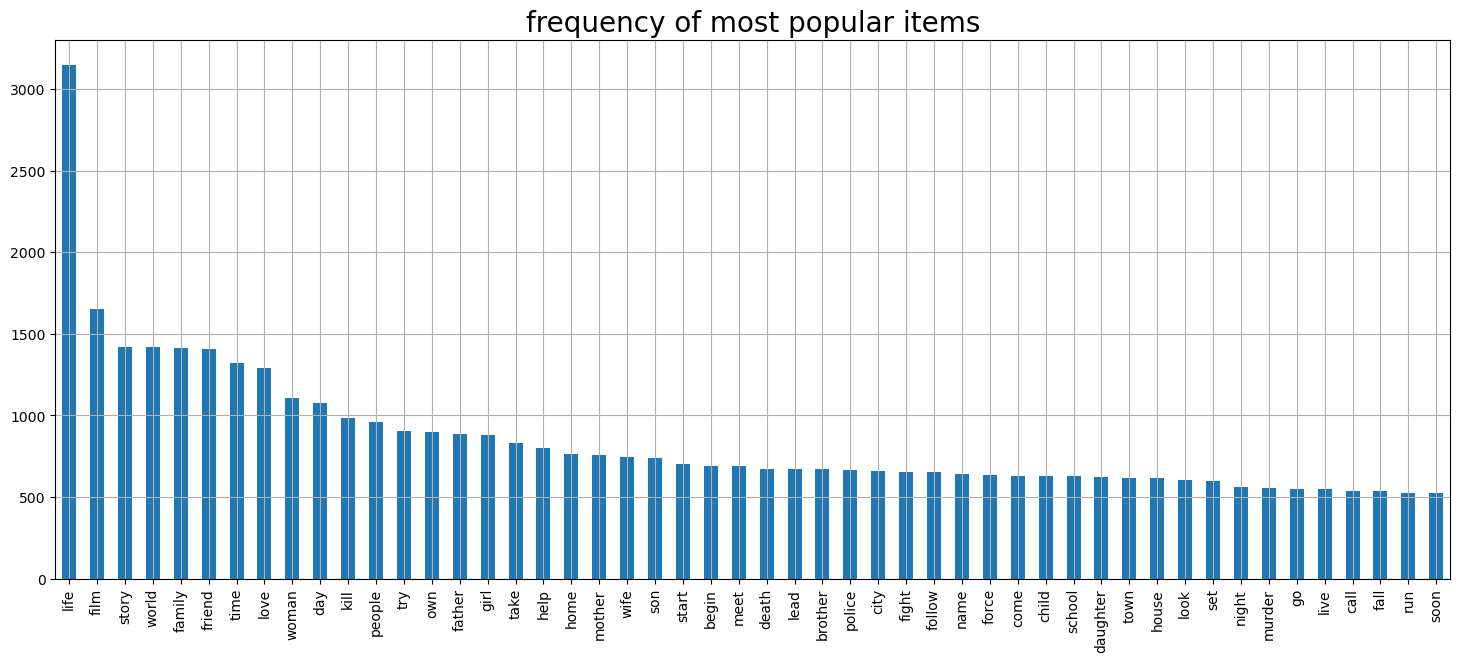

In [39]:
# looking at the frequency of most popular items 
plt.figure(figsize=(18,7))
full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [40]:
y = full_list.value_counts().head(50).to_frame()
y.index

Index(['life', 'film', 'story', 'world', 'family', 'friend', 'time', 'love',
       'woman', 'day', 'kill', 'people', 'try', 'own', 'father', 'girl',
       'take', 'help', 'home', 'mother', 'wife', 'son', 'start', 'begin',
       'meet', 'death', 'lead', 'brother', 'police', 'city', 'fight', 'follow',
       'name', 'force', 'come', 'child', 'school', 'daughter', 'town', 'house',
       'look', 'set', 'night', 'murder', 'go', 'live', 'call', 'fall', 'run',
       'soon'],
      dtype='object')

In [41]:
# making each customers shopping items an identical list
trans = []
for i in range(0, 5000):
    trans.append([str(desc_data.values[i,j]) for j in range(0, 20)])

# conveting it into an numpy array
trans = np.array(trans)

# checking the shape of the array
print(trans.shape)

(5000, 20)


In [42]:
print(trans)

[['windup' 'original' 'comedy' ... 'gritty' 'cohen' 'esque']
 ['rana' 'shuvo' 'sibling' ... 'time' 'rana' 'cop']
 ['san' 'francisco' 'detective' ... 'weapon' 'ty' 'nelson']
 ...
 ['jimmy' 'tupper' 'spends' ... 'space' 'night' 'decide']
 ['scar' 'victim' 'killer' ... 'seal' 'suit' 'finger']
 ['skip' 'nighttime' 'janitor' ... 'choice' 'recollection' 'include']]


In [43]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
data_encoded = te.fit_transform(trans)
data_encoded = pd.DataFrame(data_encoded, columns = te.columns_)

# getting the shape of the data
data_encoded.shape

# 121 columns due to null values in the dataset

(5000, 18459)

In [44]:
data_encoded

,aabhaasam,aadhi,aage,aami,aanand,aapanadu,aari,aaron,aarti,aarumugam,...,zuckmayer,zulkarnain,zulu,zulzamri,zum,zun,zur,zuzana,zwar,zwicky
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
# getting correlations for 121 items would be messy 
# so let's reduce the items from 121 to 50

data_encoded = data_encoded.loc[:, y.index]

# checking the shape
data_encoded.shape

(5000, 50)

In [46]:
data_encoded

,life,film,story,world,family,friend,time,love,woman,day,...,look,set,night,murder,go,live,call,fall,run,soon
0,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [47]:
#First, let us return the items and itemsets with at least 1% support:
frequent_itemsets = apriori(data_encoded, min_support = 0.01, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.1760,(life)
1,0.0940,(film)
2,0.0980,(story)
3,0.0830,(world)
4,0.0778,(family)
...,...,...
62,0.0124,"(life, wife)"
63,0.0100,"(live, life)"
64,0.0176,"(film, story)"
65,0.0110,"(film, follow)"


In [48]:
frequent_itemsets[['support']].describe()

,support
count,67.000000
mean,0.038373
std,0.026736
min,0.010000
25%,0.018700
50%,0.034200
75%,0.043400
max,0.176000


In [49]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(life),(story),0.1760,0.0980,0.0178,0.101136,1.032004,1.0,0.000552,1.003489,0.037635,0.069477,0.003477,0.141385
1,(story),(life),0.0980,0.1760,0.0178,0.181633,1.032004,1.0,0.000552,1.006883,0.034381,0.069477,0.006836,0.141385
2,(life),(family),0.1760,0.0778,0.0140,0.079545,1.022435,1.0,0.000307,1.001896,0.026630,0.058382,0.001893,0.129747
3,(family),(life),0.0778,0.1760,0.0140,0.179949,1.022435,1.0,0.000307,1.004815,0.023794,0.058382,0.004792,0.129747
4,(life),(friend),0.1760,0.0834,0.0172,0.097727,1.171790,1.0,0.002522,1.015879,0.177918,0.071016,0.015631,0.151981
5,(friend),(life),0.0834,0.1760,0.0172,0.206235,1.171790,1.0,0.002522,1.038091,0.159944,0.071016,0.036693,0.151981
6,(time),(life),0.0710,0.1760,0.0132,0.185915,1.056338,1.0,0.000704,1.012180,0.057409,0.056459,0.012033,0.130458
7,(life),(time),0.1760,0.0710,0.0132,0.075000,1.056338,1.0,0.000704,1.004324,0.064725,0.056459,0.004306,0.130458
8,(life),(love),0.1760,0.0558,0.0158,0.089773,1.608830,1.0,0.005979,1.037323,0.459260,0.073148,0.035980,0.186463
9,(love),(life),0.0558,0.1760,0.0158,0.283154,1.608830,1.0,0.005979,1.149480,0.400795,0.073148,0.130041,0.186463


In [50]:
rules_l.sort_values('lift', ascending = False, inplace = True)
rules_l.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
29,(fall),(love),0.0262,0.0558,0.0100,0.381679,6.840132,1.0,0.008538,1.527040,0.876776,0.138889,0.345138,0.280445
28,(love),(fall),0.0558,0.0262,0.0100,0.179211,6.840132,1.0,0.008538,1.186420,0.904262,0.138889,0.157128,0.280445
27,(follow),(film),0.0484,0.0940,0.0110,0.227273,2.417795,1.0,0.006450,1.172471,0.616225,0.083714,0.147100,0.172147
26,(film),(follow),0.0940,0.0484,0.0110,0.117021,2.417795,1.0,0.006450,1.077716,0.647241,0.083714,0.072111,0.172147
25,(story),(film),0.0980,0.0940,0.0176,0.179592,1.910551,1.0,0.008388,1.104328,0.528371,0.100917,0.094472,0.183413
24,(film),(story),0.0940,0.0980,0.0176,0.187234,1.910551,1.0,0.008388,1.109791,0.526039,0.100917,0.098929,0.183413
23,(life),(live),0.1760,0.0336,0.0100,0.056818,1.691017,1.0,0.004086,1.024617,0.495922,0.050100,0.024025,0.177219
22,(live),(life),0.0336,0.1760,0.0100,0.297619,1.691017,1.0,0.004086,1.173153,0.422848,0.050100,0.147596,0.177219
8,(life),(love),0.1760,0.0558,0.0158,0.089773,1.608830,1.0,0.005979,1.037323,0.459260,0.073148,0.035980,0.186463
9,(love),(life),0.0558,0.1760,0.0158,0.283154,1.608830,1.0,0.005979,1.149480,0.400795,0.073148,0.130041,0.186463


<Axes: >

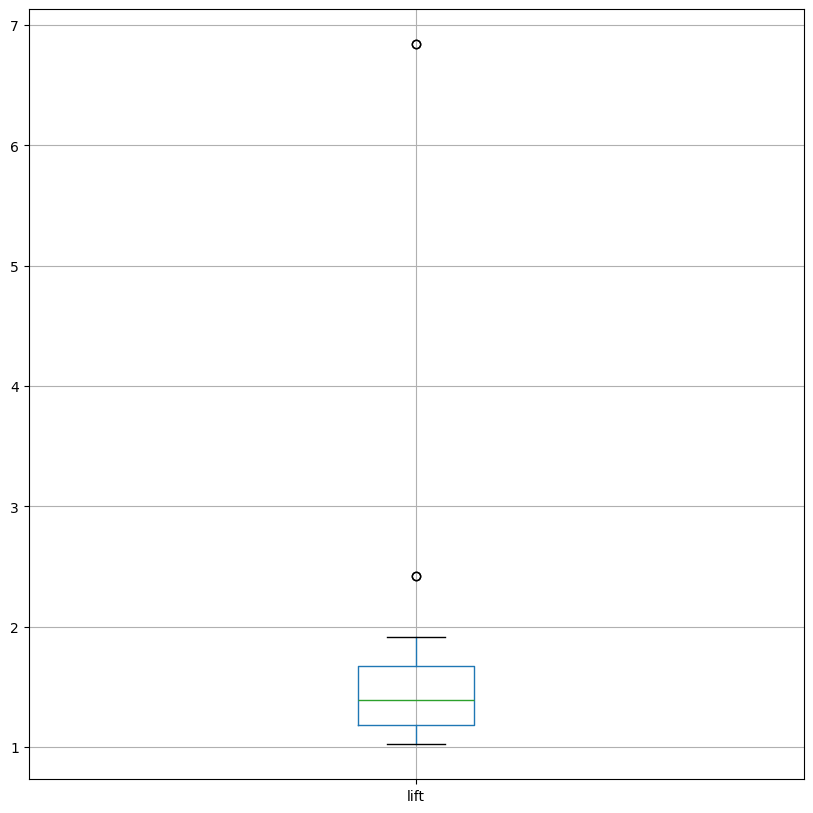

In [51]:
rules_l[['lift']].boxplot()

### MODELLING.

In [52]:
# check class distribution
print("Genre distribution:")
print(dat["Genre"].value_counts())
print(f"\nTotal samples: {len(dat)}")

Genre distribution:
Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

Total samples: 5000


In [53]:
# remove rows with missing genre or description

model_data = dat.dropna(subset=['Description', 'Genre']).copy()
print(f"Data after removing NaN: {len(model_data)} samples")

Data after removing NaN: 5000 samples


In [54]:
valid_indices = model_data.index

X = tfidf_matrix[valid_indices]  # Use TF-IDF features
y = model_data['Genre'].values

X_dense = X.toarray()

print(X.shape)
print(X_dense.shape)
print(y.shape)

(5000, 5000)
(5000, 5000)
(5000,)


In [55]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y_encoded, 
    train_size=(.60), 
    random_state=42, 
    stratify=y_encoded
)

### 1st round of training

In [ ]:
# define model hyperparams

first_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
}

first_results = {}

for name, model in first_models.items():
    print(f"Training {model}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(model, X_train, y_train, cv=7)

    first_results[name] = {
        "model": model,
        "accuracy": accuracy,
        "cv_mean": cv_score.mean(),
        "cv_std": cv_score.std(),
        "predictions": y_pred
    }

    print(f"Accuracy: {accuracy:.4f}\n")


Training LogisticRegression(max_iter=1000, random_state=42)
Accuracy: 0.6935

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       400
           1       0.63      0.64      0.64       400
           2       0.79      0.81      0.80       400
           3       0.58      0.59      0.59       400
           4       0.72      0.71      0.72       400

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

Training RandomForestClassifier(random_state=42)


/opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.12/ast.

KeyboardInterrupt: 

In [59]:
results_df = pd.DataFrame({
    'Model': first_results.keys(),
    'Test Accuracy': [first_results[model]['accuracy'] for model in first_results.keys()],
    'CV Mean': [first_results[model]['cv_mean'] for model in first_results.keys()],
    'CV Std': [first_results[model]['cv_std'] for model in first_results.keys()]
})

results_df = results_df.sort_values('Test Accuracy', ascending=False)
print("\nModel Performance Summary:\n")
print(results_df)


Model Performance Summary:

                 Model  Test Accuracy   CV Mean    CV Std
0  Logistic Regression         0.6935  0.692010  0.020393
1        Random Forest         0.6105  0.629322  0.027502
2          Naive Bayes         0.4630  0.461678  0.019799


In [60]:
best_model_name = results_df.iloc[0]['Model']
best_model = first_results[best_model_name]['model']
best_predictions = first_results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {first_results[best_model_name]['accuracy']:.4f}")

Best Model: Logistic Regression
Test Accuracy: 0.6935


In [ ]:
print("\nClassification Report:")
report = classification_report(
    y_test, 
    best_predictions,
    target_names=label_encoder.classes_,
    output_dict=True
)
print(classification_report(y_test, best_predictions, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

      action       0.74      0.71      0.73       400
      comedy       0.63      0.64      0.64       400
 documentary       0.79      0.81      0.80       400
       drama       0.58      0.59      0.59       400
    thriller       0.72      0.71      0.72       400

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



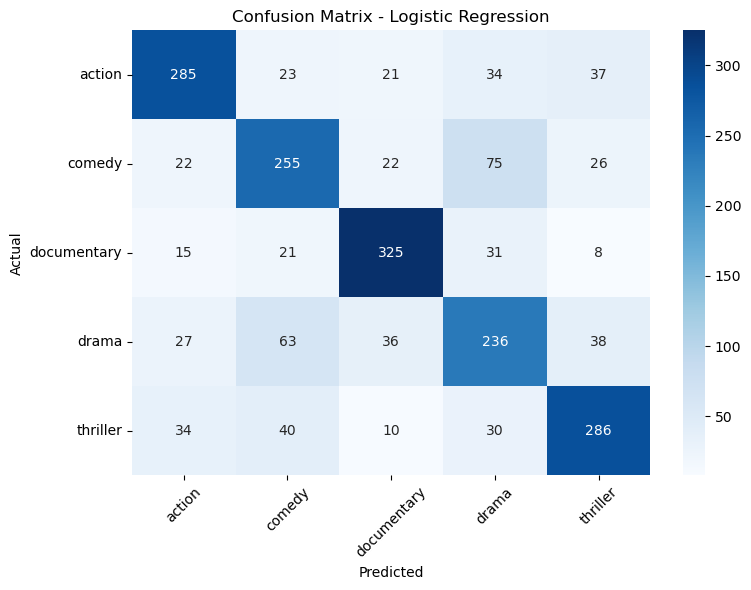

In [65]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### GridSearchCV

In [69]:
# since LR gave back best results, we tune for LR
from sklearn.metrics import make_scorer

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# custom f1 scorer for gscv
f1_scorer = make_scorer(f1_score, average="macro")

In [ ]:
tuning_model = LogisticRegression(random_state=42, max_iter=1000)

grid_search = GridSearchCV(
    tuning_model, 
    param_grid, 
    cv=5, 
    scoring=f1_scorer,
    n_jobs=-1   # use all processors
)

grid_search.fit(X_train, y_train)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'neg_mean_squared_error', 'jaccard_weighted', 'roc_auc_ovr_weighted', 'mutual_info_score', 'max_error', 'accuracy', 'neg_mean_poisson_deviance', 'precision', 'neg_root_mean_squared_log_error', 'f1_macro', 'roc_auc_ovr', 'normalized_mutual_info_score', 'precision_micro', 'neg_brier_score', 'neg_negative_likelihood_ratio', 'neg_mean_absolute_error', 'roc_auc_ovo_weighted', 'neg_mean_squared_log_error', 'f1_samples', 'jaccard_micro', 'recall_micro', 'adjusted_rand_score', 'matthews_corrcoef', 'neg_log_loss', 'adjusted_mutual_info_score', 'average_precision', 'precision_weighted', 'v_measure_score', 'r2', 'rand_score', 'jaccard', 'balanced_accuracy', 'f1_weighted', 'neg_median_absolute_error', 'completeness_score', 'neg_root_mean_squared_error', 'precision_macro', 'top_k_accuracy', 'recall', 'positive_likelihood_ratio', 'recall_macro', 'roc_auc_ovo', 'recall_weighted', 'explained_variance', 'fowlkes_mallows_score', 'precision_samples', 'jaccard_samples', 'recall_samples', 'neg_mean_gamma_deviance', 'f1', 'neg_mean_absolute_percentage_error', 'jaccard_macro', 'roc_auc', 'd2_absolute_error_score', 'homogeneity_score', 'f1_micro'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'f1_score' instead.